In [1]:
from pyspark.sql import SparkSession

In [2]:
spark = SparkSession.builder.appName("taxi-analysis").getOrCreate()

22/07/05 19:49:33 WARN Utils: Your hostname, dongwoo.local resolves to a loopback address: 127.0.0.1; using 192.168.55.122 instead (on interface en0)
22/07/05 19:49:33 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/07/05 19:49:34 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# 데이터 프레임 생성

In [3]:
trip_files = '/Users/dongwoo/new_york/data/trips/*' # 모든 파일을 가져온다.
zone_file = '/Users/dongwoo/new_york/data/taxi+_zone_lookup.csv' 

In [4]:
trips_df = spark.read.parquet(f"file:///{trip_files}", inferSchema=True, header=True)
zone_df = spark.read.csv(f"file:///{zone_file}", inferSchema=True, header=True)

### 스키마 파싱

In [5]:
trips_df.printSchema()
zone_df.printSchema()

root
 |-- VendorID: long (nullable = true)
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- tpep_dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: double (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: long (nullable = true)
 |-- DOLocationID: long (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- airport_fee: double (nullable = true)

root
 |-- LocationID: integer (nullable = true)
 |-- Borough: string (nullable = true)
 |-- Zone: string (nullable = true)
 |-- service_zo

### 쿼리

In [6]:
trips_df.createOrReplaceTempView('trips') # trips 라는 테이블로 Temporary View에 저장한다.
zone_df.createOrReplaceTempView('zone')

In [16]:
query = '''
SELECT
    t.VendorID AS vender_id,
    TO_DATE(t.tpep_pickup_datetime) AS pickup_date,
    TO_DATE(t.tpep_dropoff_datetime) AS dropoff_date,
    HOUR(t.tpep_pickup_datetime) AS pickup_time,
    HOUR(t.tpep_dropoff_datetime) AS dropoff_time,
    t.passenger_count,
    t.trip_distance,
    t.fare_amount,
    t.tip_amount,
    t.tolls_amount,
    t.total_amount,
    t.payment_type,
    
    pz.zone AS pickup_zone,
    dz.zone AS dropoff_zone
FROM
    trips AS t
    LEFT JOIN
        zone AS pz
    ON
        t.PULocationID = pz.LocationID
    LEFT JOIN
        zone AS dz
    ON
        t.DOLocationID = dz.LocationID
'''
combination_df = spark.sql(query)
# combination_df.show()
combination_df.createOrReplaceTempView('comb')

In [17]:
combination_df.printSchema()

root
 |-- vender_id: long (nullable = true)
 |-- pickup_date: date (nullable = true)
 |-- dropoff_date: date (nullable = true)
 |-- pickup_time: integer (nullable = true)
 |-- dropoff_time: integer (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- pickup_zone: string (nullable = true)
 |-- dropoff_zone: string (nullable = true)



```sql
SELECT
    t.VendorID AS vender_id, -- vender ID
    TO_DATE(t.tpep_pickup_datetime) AS pickup_date, -- 상차 날짜
    TO_DATE(t.tpep_dropoff_datetime) AS dropoff_date, -- 하차 날짜
    HOUR(t.tpep_pickup_datetime) AS pickup_time, -- 상차 시간
    HOUR(t.tpep_dropoff_datetime) AS dropoff_time, -- 하차 시간
    t.passenger_count, -- 탑승자 수
    t.trip_distance, -- 운행 길이
    t.fare_amount,-- 운행 요금
    t.tip_amount, 
    t.tolls_amount,
    t.total_amount, -- 전체 지불 
    t.payment_type, -- 지불 타입
    
    pz.zone AS pickup_zone,
    dz.zone AS dropoff_zone
FROM
    trips AS t
    LEFT JOIN -- pickup
        zone AS pz
    ON
        t.PULocationID = pz.LocationID
        
    LEFT JOIN -- dropoff
        zone AS dz
    ON
        t.DOLocationID = dz.LocationID
```

# 데이터 클리닝

### 데이터 확인

In [19]:
spark.sql("SELECT pickup_date, pickup_time FROM comb WHERE pickup_date < '2020-12-31' ").show()

+-----------+-----------+
|pickup_date|pickup_time|
+-----------+-----------+
| 2009-01-01|          9|
| 2009-01-01|          8|
| 2009-01-01|          8|
| 2009-01-01|          8|
| 2009-01-01|          8|
| 2009-01-01|          8|
| 2009-01-01|          9|
| 2009-01-01|          9|
| 2009-01-01|         10|
| 2009-01-01|         11|
| 2009-01-01|          9|
| 2009-01-01|          8|
| 2009-01-01|         10|
| 2009-01-01|          7|
| 2009-01-01|          8|
| 2009-01-01|          8|
| 2009-01-01|          8|
| 2003-01-09|         16|
| 2009-01-01|          8|
| 2009-01-01|          8|
+-----------+-----------+
only showing top 20 rows



In [20]:
combination_df.select('total_amount').describe().show()

+-------+------------------+
|summary|      total_amount|
+-------+------------------+
|  count|          30904308|
|   mean|19.696304829291634|
| stddev|179.19426093049208|
|    min|            -951.0|
|    max|         818286.74|
+-------+------------------+



In [21]:
combination_df.select('trip_distance').describe().show()

+-------+-----------------+
|summary|    trip_distance|
+-------+-----------------+
|  count|         30904308|
|   mean|6.922688674342763|
| stddev| 698.379951118258|
|    min|              0.0|
|    max|        351613.36|
+-------+-----------------+



`max`값이 엄청 높게 나왔다.

In [22]:
combination_df.select('passenger_count').describe().show()

+-------+------------------+
|summary|   passenger_count|
+-------+------------------+
|  count|          29425613|
|   mean|1.4274682399989425|
| stddev|1.0333753094086533|
|    min|               0.0|
|    max|             112.0|
+-------+------------------+



`max`값이 112명인것은 뭔가 오류가 있는듯하다.

In [27]:
query = """
SELECT
    DATE_TRUNC('MM', c.pickup_date) AS month,
    COUNT(*) AS trips
FROM
    comb AS c
GROUP BY
    month
ORDER BY
    month desc
"""
spark.sql(query).show()

+-------------------+-------+
|              month|  trips|
+-------------------+-------+
|2098-09-01 00:00:00|      1|
|2070-08-01 00:00:00|      1|
|2029-05-01 00:00:00|      1|
|2028-12-01 00:00:00|      1|
|2022-03-01 00:00:00|      3|
|2022-02-01 00:00:00|     10|
|2022-01-01 00:00:00|  38010|
|2021-12-01 00:00:00|3238869|
|2021-11-01 00:00:00|3455031|
|2021-10-01 00:00:00|3481005|
|2021-09-01 00:00:00|2950798|
|2021-08-01 00:00:00|2788555|
|2021-07-01 00:00:00|2825512|
|2021-06-01 00:00:00|2813017|
|2021-05-01 00:00:00|2522860|
|2021-04-01 00:00:00|2156143|
|2021-03-01 00:00:00|1910234|
|2021-02-01 00:00:00|1368619|
|2021-01-01 00:00:00|1355332|
|2020-12-01 00:00:00|      1|
+-------------------+-------+
only showing top 20 rows



### 데이터 클리닝
```sql
SELECT
    *
FROM 
    comb AS c
WHERE
    c.total_amount < 1000 -- 택시비가 1000 이하
    AND c.trip_distance < 100 -- 거리가 100마일 이하
    AND c.total_amount > 0 -- 이상치 제거
    AND c.passenger_count < 5 -- 택시 탄 인원이 4명 정도 까지
    AND c.pickup_date >= '2021-01-01' -- 픽업 날짜 기준
    AND c.pickup_date < '2022-01-01'
```

In [30]:
query = """
SELECT
    *
FROM 
    comb AS c
WHERE
    c.total_amount < 1000
    AND c.trip_distance < 100
    AND c.total_amount > 0
    AND c.passenger_count < 5
    AND c.pickup_date >= '2021-01-01'
    AND c.pickup_date < '2022-01-01'

"""

cleaned_df = spark.sql(query)
cleaned_df.createOrReplaceTempView('cleaned')

In [31]:
cleaned_df.describe().show()

+-------+------------------+-----------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+--------------------+--------------------+
|summary|         vender_id|      pickup_time|     dropoff_time|   passenger_count|     trip_distance|       fare_amount|        tip_amount|      tolls_amount|      total_amount|       payment_type|         pickup_zone|        dropoff_zone|
+-------+------------------+-----------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+--------------------+--------------------+
|  count|          28074691|         28074691|         28074691|          28074691|          28074691|          28074691|          28074691|          28074691|          28074691|           28074691|            28074691|            28074691|
|   mean|1.6765079266589256|10.86415

# Visualization

In [57]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.express as px

In [58]:
query = """
SELECT
    c.pickup_date,
    COUNT(*) AS trips
FROM
    cleaned AS c
GROUP BY
    c.pickup_date
"""

pd_df = spark.sql(query).toPandas() # 판다스 형식으로 변경

Text(0.5, 1.0, 'Taxi Utilization by Date')

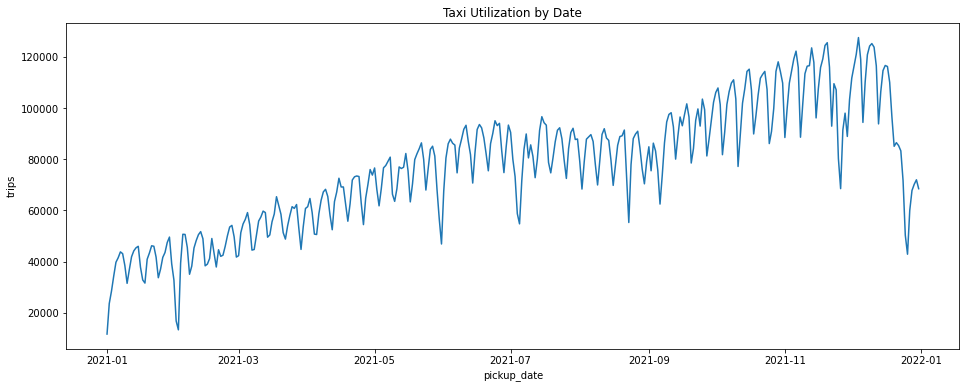

In [62]:
fig, ax = plt.subplots(figsize=(16,6)) # 도화지 생성
v1 = sns.lineplot(x="pickup_date", y="trips", data=pd_df)
v1.set_title("Taxi Utilization by Date")

# fig = px.line(pd_df, x="pickup_date", y="trips", title="Taxi Utilization by Date")
# fig.show()

- 택시 이용률이 점점 늘어나는 것을 확인할 수 있다.
- 요일 마다 변화가 있는 것을 확인할 수 있다.

In [43]:
query = """
SELECT
    c.pickup_date,
    DATE_FORMAT(c.pickup_date, 'EEEE') AS day_of_week,
    COUNT(*) AS trips
FROM
    cleaned AS c
GROUP BY
    c.pickup_date,
    day_of_week
"""

pd_df2 = spark.sql(query).toPandas() # 판다스 형식으로 변경

In [46]:
data = pd_df2.groupby("day_of_week").trips.median().to_frame().reset_index()
data["sort_dow"] = data["day_of_week"].replace({
    "Sunday": 0,
    "Monday": 1,
    "Tuesday": 2,
    "Wednesday": 3,
    "Thursday": 4,
    "Friday" : 5,
    "Saturday" : 6
})

data.sort_values(by="sort_dow", inplace=True) # 위 형식으로 정렬

In [47]:
data

,day_of_week,trips,sort_dow
3,Sunday,77045.5,0
1,Monday,68141.5,1
5,Tuesday,77763.5,2
6,Wednesday,85369.5,3
4,Thursday,87374.0,4
0,Friday,84097.0,5
2,Saturday,85922.0,6


In [65]:
# fig, ax = plt.subplots(figsize=(12,5))
# sns.barplot(
#     x= 'day_of_week',
#     y= 'trips',
#     data = data
# )

fig = px.bar(data, x="day_of_week", y="trips", title="Taxi Utilization by day of week")
fig.show()

- 월요일이 가장 적다는 것을 알 수 있다.

In [49]:
def get_weekday(data):
    import calendar
    return calendar.day_name[date.weekday()]

spark.udf.register("get_weekday", get_weekday)

<function __main__.get_weekday(data)>

`DATE_FORMAT(c.pickup_date, 'EEEE')` 대신에 `get_weekday`라는 함수를 새로 지정해 사용해도 된다.

In [50]:
query = """
SELECT
    c.pickup_date,
    get_weekday(c.pickup_date) AS day_of_week,
    COUNT(*) AS trips
FROM
    cleaned AS c
GROUP BY
    c.pickup_date,
    day_of_week

"""

In [51]:
payment_type_to_string = {
        1: "Credit Card",
        2: "Cash",
        3: "No Charge",
        4: "Dispute",
        5: "Unknown",
        6: "Voided Trip",
}

def parse_payment_type(payment_type):
    return payment_type_to_string[payment_type]

spark.udf.register("parse_payment_type", parse_payment_type)

<function __main__.parse_payment_type(payment_type)>

In [68]:
query = """
SELECT
    parse_payment_type(payment_type),
    count(*) AS trips,
    MEAN(fare_amount) AS mean_fare_amount,
    STD(fare_amount) AS stdev_fare_amount
FROM
    cleaned
GROUP BY
    payment_type

"""

pr = spark.sql(query).toPandas()

In [69]:
pr

,parse_payment_type(payment_type),trips,mean_fare_amount,stdev_fare_amount
0,Unknown,2,10.900000,9.758074
1,Credit Card,21554749,13.071420,11.722678
2,No Charge,112051,12.355888,16.518893
3,Cash,6361606,12.715889,11.995927
4,Dispute,46283,13.208797,15.948671


- Dispute : 분쟁이 있는 경우
- Creait Card 로 계산한 사람이 많음.